In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#!pip install lingpy
#import lingpy
#from lingpy import ipa2tokens
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu") #For debugging
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
dat = pd.read_csv('data/ielexData.csv')

In [4]:
dat

,Unnamed: 0,Language,Meaning,Phonological Form,cc,ASJP
0,11,Greek,few,ˈliʝi,few:I,liSi
1,63,Bulgarian,few,ˈmaɫku,few:H,maLku
2,65,Russian,few,'maɫɔ,few:H,maLo
3,66,Polish,few,ˈmawɔ,few:H,mawo
4,68,Ukrainian,few,ˈmaɫɔ,few:H,maLo
...,...,...,...,...,...,...
4479,124,French,head,tɛt,head:D,tEt
4480,135,Italian,head,'tɛsta,head:D,tEsta
4481,136,Romanian,head,kap,head:B,kap
4482,143,Breton,head,ˈpɛnː,head:E,pEn


In [5]:
dat[dat['Meaning'] == 'few']

,Unnamed: 0,Language,Meaning,Phonological Form,cc,ASJP
0,11,Greek,few,ˈliʝi,few:I,liSi
1,63,Bulgarian,few,ˈmaɫku,few:H,maLku
2,65,Russian,few,'maɫɔ,few:H,maLo
3,66,Polish,few,ˈmawɔ,few:H,mawo
4,68,Ukrainian,few,ˈmaɫɔ,few:H,maLo
5,70,Czech,few,ˈmaːlɔ,few:H,malo
6,79,Icelandic,few,ˈfauːɪr,few:F,fauir
7,84,Swedish,few,foː,few:F,fo
8,89,Danish,few,fɔˀ,few:F,fo
9,93,English,few,fju:,few:F,fyu


In [6]:
concepts = [re.sub(':.*', '', x) for x in dat['cc']]
dat['concepts'] = concepts
uniqueconcepts = np.unique(concepts)
cognates = [list(re.sub('^.*:', '', x))[0] for x in dat['cc']]
dat['cognate_char'] = cognates

In [7]:
source_words = []
target_words = []
label = []
for concept in uniqueconcepts:
  tmp_df = dat[dat['concepts'] == concept]
  for word_idx in range(len(tmp_df)):
    source_word = tmp_df['ASJP'].iloc[word_idx]
    source_class = tmp_df['cognate_char'].iloc[word_idx]
    if len(list(source_word)) < 11:
      for word_idx2 in range(len(tmp_df)):
        if word_idx != word_idx2:
          target_word = tmp_df['ASJP'].iloc[word_idx2]
          target_class = tmp_df['cognate_char'].iloc[word_idx2]
          if len(list(target_word)) < 11:
            if source_class == target_class:
              label.append(1)
            else:
              label.append(0)
            source_words.append(source_word)
            target_words.append(target_word)


In [8]:
source_words[0]

'exo'

In [9]:
charlens = []
unique_characters = []
for i in source_words:
  charlens.append(len(list(i)))
  for j in list(i):
    unique_characters.append(j)
unique_characters = ['PAD'] + np.unique(unique_characters).tolist()

In [10]:
maxlen = max(charlens)

In [11]:
source_words_tokens = []
target_words_tokens = []
for j in range(len(source_words)):
  source_tmp = [unique_characters.index(i) for i in list(source_words[j])]
  target_tmp = [unique_characters.index(i) for i in list(target_words[j])]
  source_tmp = source_tmp + [0 for x in range(maxlen-len(source_tmp))]
  target_tmp = target_tmp + [0 for x in range(maxlen-len(target_tmp))]

  source_words_tokens.append(source_tmp)
  target_words_tokens.append(target_tmp)

In [12]:
source_words_tokens[0], target_words_tokens[0]

([15, 33, 25, 0, 0, 0, 0, 0, 0, 0], [25, 23, 19, 0, 0, 0, 0, 0, 0, 0])

In [13]:
unique_characters[25]

'o'

In [14]:
#indices = np.arange(len(source_words_tokens))
#np.random.shuffle(indices)
#split_index = int(0.9 * len(indices))
#train_indices = indices[:split_index]
#test_indices = indices[split_index:]

In [15]:
#source_words_tokens_train = source_words_tokens[train_indices]
#source_words_tokens_test = source_words_tokens[test_indices]
#target_words_tokens_train = target_words_tokens[train_indices]
#target_words_tokens_test = target_words_tokens[test_indices]
#label_train = label[train_indices]
#label_test = label[test_indices]

In [16]:
from sklearn.model_selection import train_test_split
source_train, source_test, target_train, target_test, label_train, label_test = train_test_split(source_words_tokens, target_words_tokens, label, test_size=0.1, shuffle=True, random_state=42)

In [17]:
source_train_tensor = torch.tensor(source_train, dtype=torch.long, device=device)
source_test_tensor = torch.tensor(source_test, dtype=torch.long, device=device)
target_train_tensor = torch.tensor(target_train, dtype=torch.long, device=device)
target_test_tensor = torch.tensor(target_test, dtype=torch.long, device=device)
label_train_tensor = torch.tensor(label_train, dtype=torch.int, device=device)
label_test_tensor = torch.tensor(label_test, dtype=torch.int, device=device)

In [18]:
train_dataset = TensorDataset(source_train_tensor, target_train_tensor, label_train_tensor)
test_dataset = TensorDataset(source_test_tensor, target_test_tensor, label_test_tensor)

In [19]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size = batch_size, generator=torch.Generator(device=device.type))
test_loader = DataLoader(test_dataset, batch_size = batch_size, generator=torch.Generator(device=device.type))

Next step: NN that takes in both words, converts them to embeddings and predicts whether they are cognates (yes/no) = (1/0), sigmoid classification

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class SimpleCognateDataset(Dataset):
    def __init__(self, data, unique_characters, maxlen):
        self.data = data
        self.char_to_idx = {char: i+1 for i, char in enumerate(unique_characters)}
        self.maxlen = maxlen

    def encode_word(self, word):
        #This is way faster than the "proper method"
        #Because all the data on the cpu device, so making a tensor would send it to the gpu, then pull it from the gpu, then send it again
        #Maybe if we could make this dataset once and put it on the gpu once, then it would be way faster
        encoded = [self.char_to_idx.get(c, 0) for c in word]
        return encoded + [0] * (self.maxlen - len(encoded))
    
        #encoded = [self.char_to_idx.get(c, 0) for c in word]
        #return nn.functional.pad(torch.tensor(encoded, dtype=torch.long), (0, self.maxlen - len(encoded)), value=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        word1, word2, label = self.data[idx]
        return (
            torch.tensor(self.encode_word(word1), dtype=torch.long, device=device),
            torch.tensor(self.encode_word(word2), dtype=torch.long, device=device),
            torch.tensor(label, dtype=torch.float, device=device)
        )

In [21]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("data/ielexData.csv")

df = df[['Meaning', 'Phonological Form', 'cc']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

ilexPairs = []

for _, group in df.groupby('meaning'):
    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        label = int(w1['cognate_class'] == w2['cognate_class'])
        ilexPairs.append((word1, word2, label))

import csv

# Initialize an empty set to store the languages
languages = set()

# Open and read the CSV file with UTF-8 encoding and error handling
with open('data/ielexData.csv', 'r', encoding='utf-8', errors='replace') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        languages.add(row[1])  # Add the language (second column) to the set

# Print the set of languages
print(languages)

df

{'Hindi', 'Romanian', 'French', 'Bulgarian', 'Spanish', 'Bengali', 'Russian', 'Portuguese', 'Ukrainian', 'Nepali', 'Catalan', 'Irish', 'Icelandic', 'Italian', 'Welsh', 'English', 'Danish', 'Czech', 'Polish', 'Breton', 'Swedish', 'Dutch', 'Lithuanian', 'German', 'Greek'}


,meaning,word,cognate_class
0,few,ˈliʝi,few:I
1,few,ˈmaɫku,few:H
2,few,'maɫɔ,few:H
3,few,ˈmawɔ,few:H
4,few,ˈmaɫɔ,few:H
...,...,...,...
4479,head,tɛt,head:D
4480,head,'tɛsta,head:D
4481,head,kap,head:B
4482,head,ˈpɛnː,head:E


In [22]:
df = pd.read_csv("data/gled.tsv", delimiter="\t")

df.rename(columns={'LANGUAGE_NAME': 'Language'}, inplace=True)

df['Language'] = df['Language'].str.replace('Modern Greek', 'Greek', regex=False)

df = df[df['Language'].isin(languages)]

#df = df[df.apply(lambda row: row['DOCULECT'].lower() in row['Language'].lower(), axis=1)]

#These languages seem to be aight
#df = df[df["DOCULECT"].str.contains("_2")]

#df.dropna(subset=["COGSET"], inplace=True) All of them have a cogset

df

,ID,DOCULECT,Language,GLOTTOCODE,GLOTTOLOG_NAME,FAMILY,CONCEPT,CONCEPTICON_ID,ASJP_FORM,FORM,IPA,ALIGNMENT,COGSET,COGSET_INT
144314,BRETON.1pl-3159,BRETON,Breton,bret1244,Breton,Indo-European,1pl,1212,ni,ni,n i,n i - - - -,indoeuropean.1pl.0001,18691
144315,BULGARIAN_2.1pl-3162,BULGARIAN_2,Bulgarian,bulg1262,Bulgarian,Indo-European,1pl,1212,niE,nia,n i a,n i - - - a,indoeuropean.1pl.0001,18691
144321,FRENCH_2.1pl-3210,FRENCH_2,French,stan1290,French,Indo-European,1pl,1212,nu,nu,n u,n u - - - -,indoeuropean.1pl.0001,18691
144324,ITALIAN_2.1pl-3242,ITALIAN_2,Italian,ital1282,Italian,Indo-European,1pl,1212,noi,noi,n o i,n o - - - i,indoeuropean.1pl.0001,18691
144325,ITALIAN_GROSSETO_TUSCAN.1pl-3243,ITALIAN_GROSSETO_TUSCAN,Italian,ital1282,Italian,Indo-European,1pl,1212,noi,noi,n o i,n o - - - i,indoeuropean.1pl.0001,18691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158460,IRISH_GAELIC.water-259902,IRISH_GAELIC,Irish,iris1253,Irish,Indo-European,water,948,iSky3,iʃkjə,i ʃ k j ə,- i - ʃ k j ə,indoeuropean.water.0950,19640
158464,GREEK.water-259881,GREEK,Greek,mode1248,Modern Greek,Indo-European,water,948,nero,nero,n e r o,n e r o,indoeuropean.water.0951,19641
158465,MODERN_GREEK.water-259969,MODERN_GREEK,Greek,mode1248,Modern Greek,Indo-European,water,948,nero,nero,n e r o,n e r o,indoeuropean.water.0951,19641
158481,HINDI_2.water-259895,HINDI_2,Hindi,hind1269,Hindi,Indo-European,water,948,j3l,dʒəl,dʒ ə l,dʒ ə l,indoeuropean.water.0961,19651


In [23]:
df = df[['CONCEPT', 'FORM', 'COGSET']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

pairs = []

from tqdm import tqdm
for _, group in tqdm(df.groupby('meaning')):
    #if len(pairs) > 100000:
    #    break

    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        if(word1 == word2):
            continue
        label = int(w1['cognate_class'] == w2['cognate_class'])
        #if label == 1:
        pairs.append((word1, word2, label))

100%|██████████| 40/40 [00:00<00:00, 1384.22it/s]


In [24]:
len(pairs)

27982

In [25]:
pairs += ilexPairs

In [26]:
pairs

[('ni', 'nia', 1),
 ('ni', 'nu', 1),
 ('ni', 'noi', 1),
 ('ni', 'noi', 1),
 ('ni', 'noʃ', 1),
 ('ni', 'noj', 1),
 ('ni', 'həm', 0),
 ('ni', 'ɐmrɐ', 0),
 ('ni', 'ma', 0),
 ('ni', 'mi', 0),
 ('ni', 'midj', 0),
 ('ni', 'mɐ', 0),
 ('ni', 'mes', 0),
 ('ni', 'mi', 0),
 ('ni', 'mə', 0),
 ('ni', 'mə', 0),
 ('ni', 'mi', 0),
 ('ni', 'noltros', 0),
 ('ni', 'nuzɐʎtrəs', 0),
 ('ni', 'nosotros', 0),
 ('ni', 'nosɐltres', 0),
 ('ni', 'vi', 0),
 ('ni', 'və', 0),
 ('ni', 'vai', 0),
 ('ni', 'wi', 0),
 ('ni', 'vir', 0),
 ('ni', 'vi', 0),
 ('ni', 'viθ', 0),
 ('ni', 'ʃinj', 0),
 ('ni', 'ʃiɲ', 0),
 ('ni', 'emis', 0),
 ('ni', 'emis', 0),
 ('ni', 'vɐalə', 0),
 ('nia', 'nu', 1),
 ('nia', 'noi', 1),
 ('nia', 'noi', 1),
 ('nia', 'noʃ', 1),
 ('nia', 'noj', 1),
 ('nia', 'ni', 1),
 ('nia', 'həm', 0),
 ('nia', 'ɐmrɐ', 0),
 ('nia', 'ma', 0),
 ('nia', 'mi', 0),
 ('nia', 'midj', 0),
 ('nia', 'mɐ', 0),
 ('nia', 'mes', 0),
 ('nia', 'mi', 0),
 ('nia', 'mə', 0),
 ('nia', 'mə', 0),
 ('nia', 'mi', 0),
 ('nia', 'noltros', 0),


In [27]:
pairs_df = pd.DataFrame(pairs, columns=['Word1', 'Word2', 'Label'])
pairs_df

,Word1,Word2,Label
0,ni,nia,1
1,ni,nu,1
2,ni,noi,1
3,ni,noi,1
4,ni,noʃ,1
...,...,...,...
75251,voj,xwi,1
75252,voj,ʃivʲ,1
75253,"ˈxwi, ˈhwi",xwi,1
75254,"ˈxwi, ˈhwi",ʃivʲ,1


In [28]:
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
import numpy as np
from tqdm import tqdm
import time

# Prepare data
all_words = [w for pair in pairs for w in pair[:2]]
all_answers = [w for pair in pairs for w in pair[2:]]
unique_characters = sorted(set("".join(all_words)))
maxlen = max(len(w) for w in all_words)

def cv_test_model(model_maker, has_history=False):
	cv = StratifiedKFold(n_splits = 5)
	epochs = 15

	# Store results for each fold
	# All of these are [epoch_number, fold, (confusion_matrix, accuracy)]
	
	history = {
		"train": [
			[tuple((None, None)) for _ in range(cv.get_n_splits())]
			for _ in range(epochs)
		],
		"test": [
			[tuple((None, None)) for _ in range(cv.get_n_splits())]
			for _ in range(epochs)
		]
	}

	for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(pairs_df.iloc[:, :2], pairs_df.iloc[:, 2:]), total=cv.get_n_splits(), desc="CV Progress")):
		# Split data
		train_data = [pairs[i] for i in train_idx]
		test_data = [pairs[i] for i in test_idx]
		
		# Create model for this fold
		model = model_maker()
		criterion = nn.BCELoss()
		optimizer = optim.Adam(model.parameters(), lr=0.001)
		
		# Create datasets and dataloaders
		train_dataset = SimpleCognateDataset(train_data, unique_characters, maxlen)
		test_dataset = SimpleCognateDataset(test_data, unique_characters, maxlen)
		
		train_loader = DataLoader(train_dataset, batch_size=3200, shuffle=True, 
								generator=torch.Generator(device=device.type))
		test_loader = DataLoader(test_dataset, batch_size=3200, 
								generator=torch.Generator(device=device.type))
		
		
		def test_against_loader(model, loader):
			"""
			Modified test_against_loader that returns predictions, probabilities, and true labels
			"""
			predictions = []
			probabilities = []  # Raw model outputs (probabilities)
			true_labels = []

			with torch.no_grad():
				for word1_batch, word2_batch, label_batch in loader:
					output_batch = model(word1_batch, word2_batch).squeeze()
					predicted_batch = (output_batch > 0.5).int()

					# Store results for the entire batch
					predictions.extend(predicted_batch.tolist())
					probabilities.extend(output_batch.tolist())  # Store raw probabilities
					true_labels.extend(label_batch.int().tolist())

			# Calculate accuracy
			accuracy = sum([pred == true for pred, true in zip(predictions, true_labels)]) / len(true_labels)

			# Additional metrics
			from sklearn.metrics import confusion_matrix
			
			# Calculate confusion matrix
			conf_matrix = confusion_matrix(true_labels, predictions)

			return conf_matrix, accuracy, probabilities, true_labels

		# Train model
		model.train()
		for epoch in range(epochs):
			total_loss = 0
			for word1, word2, label in train_loader:
				optimizer.zero_grad()
				output = model(word1, word2).squeeze()
				#print(output.get_device(), label.get_device())
				loss = criterion(output, label)
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			#print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

			if has_history:
				model.eval()
				history["train"][epoch][fold] = test_against_loader(model, train_loader)
				history["test"][epoch][fold] = test_against_loader(model, test_loader)

				#Early cutoff if overfitting
				if history["train"][epoch][fold][1] >= .99:
					history["train"] = history["train"][0:epoch]
					history["test"] = history["test"][0:epoch]
					return history, model
				
				model.train()

		if not has_history:
			history["test"][-1][fold] = test_against_loader(model, test_loader)

	return history, model


In [29]:
from transformer_stuff import TransformerCognateModel, UnbatchedWrapper
#from lstm_stuff import SimplePairNN
def simple_nn_model_maker():
    # Model parameters
    embedding_dim = 64
    hidden_dim = 128
    vocab_size = len(unique_characters)

    #return SimplePairNN(vocab_size, embedding_dim, hidden_dim)
    return TransformerCognateModel(vocab_size, embedding_dim, hidden_dim)


history, model = cv_test_model(simple_nn_model_maker, has_history=True)

CV Progress: 100%|██████████| 5/5 [13:26<00:00, 161.34s/it]



Cross-Validation Results:
Overall Accuracy: 74.71%
Correct Predictions: 56221/75256


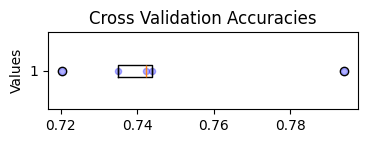

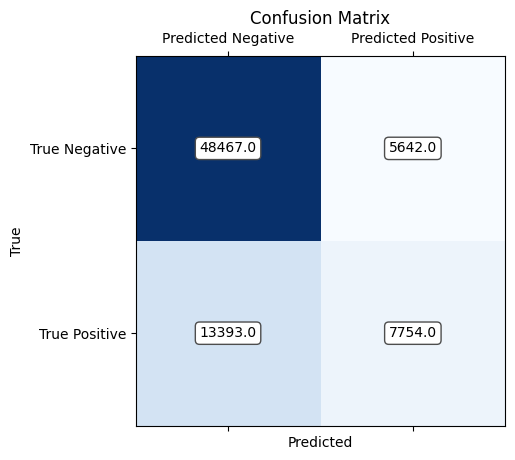

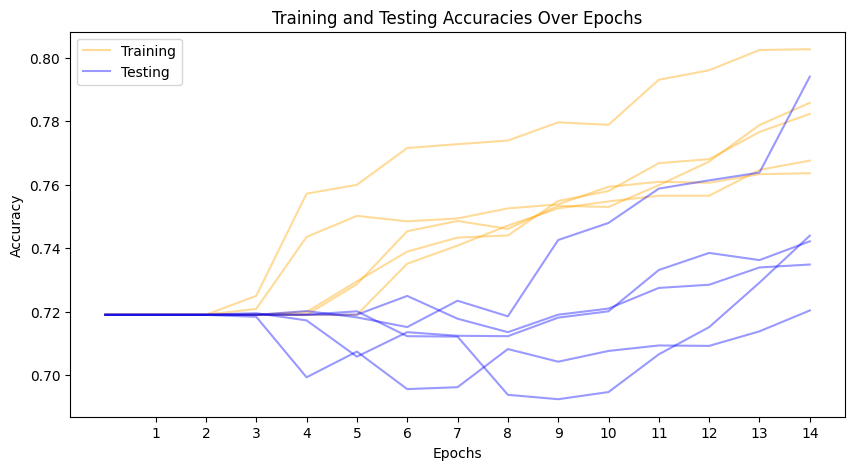

In [30]:
# Calculate overall statistics
last_epoch_test_data = history["test"][-1] #[fold, (pred, labels, accuracies, accuracy)]

all_confusion = np.sum(np.array([fold_data[0] for fold_data in last_epoch_test_data]), axis=0)
all_accuracies = [fold_data[1] for fold_data in last_epoch_test_data]

overall_accuracy = np.mean(all_accuracies)
correct_predictions = all_confusion[1][1] + all_confusion[0][0]
total_predictions = np.sum(all_confusion)

print(f"\nCross-Validation Results:")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")

fold_accuracies = [fold_data[1] for fold_data in history["test"][-1]]

from visualization_stuff import show_box_plot, show_confusion_matrix, show_train_and_test_accuracy_over_epochs
show_box_plot(fold_accuracies)

show_confusion_matrix(all_confusion)

show_train_and_test_accuracy_over_epochs(history)

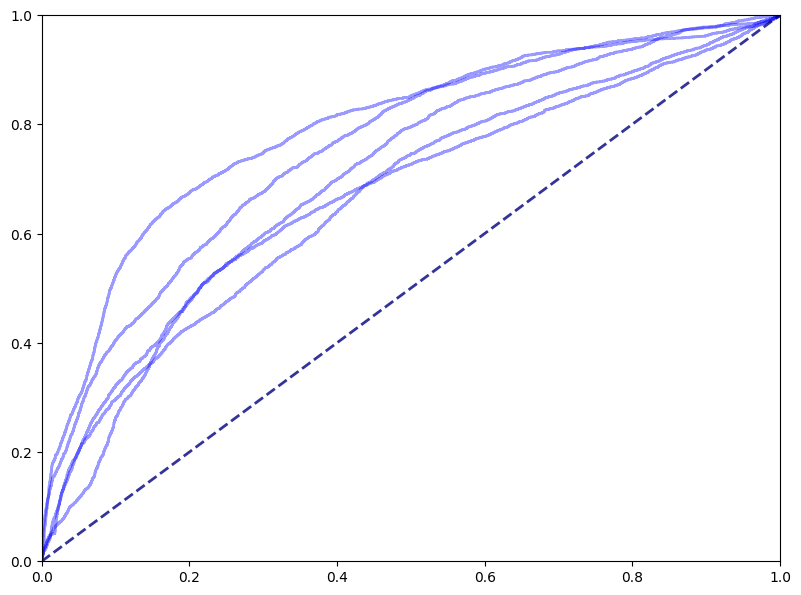

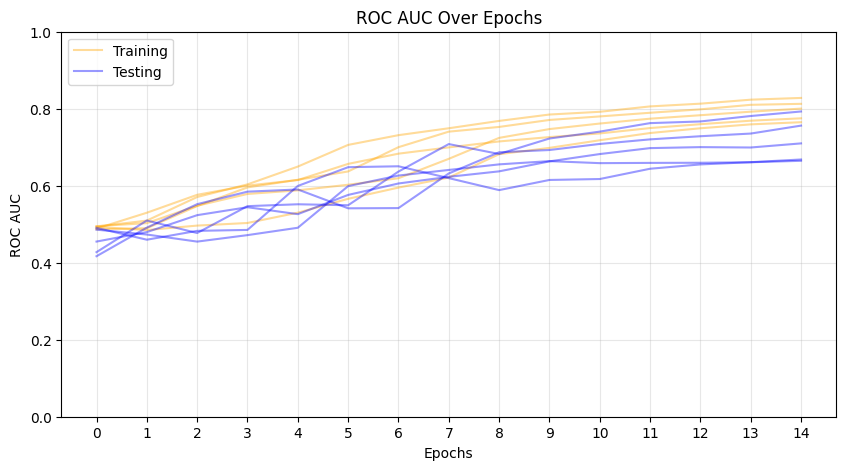

In [31]:
from visualization_stuff import show_multiple_roc_curves, show_roc_curves_over_epochs

show_multiple_roc_curves(history)

# Show ROC AUC progression over epochs (similar to accuracy plot)
train_fold_aucs, test_fold_aucs = show_roc_curves_over_epochs(history, "ROC AUC Over Epochs")

In [32]:
def show_classification_report(history):
    all_labels = []
    all_predictions = []
    for fold_data in history["test"][-1]:
        _, _, probabilities, true_labels = fold_data
        all_labels.extend(true_labels)
        all_predictions.extend([int(prob > .5) for prob in probabilities])
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_predictions))

show_classification_report(history)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84     54109
           1       0.58      0.37      0.45     21147

    accuracy                           0.75     75256
   macro avg       0.68      0.63      0.64     75256
weighted avg       0.73      0.75      0.73     75256



https://github.com/pytorch/examples/tree/main/word_language_model